Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Selected images for feature matching: ['5f4c8efc-bd36-4846-ad46-5f3c6e9a8864.JPG', '5c30916f-2905-44ec-a23f-33f5c58c8acd.JPG', 'a272a559-d178-4ee8-9f48-57c0cab17e18.JPG', '238dea14-877f-4580-8359-c6f46c81f68b.JPG']


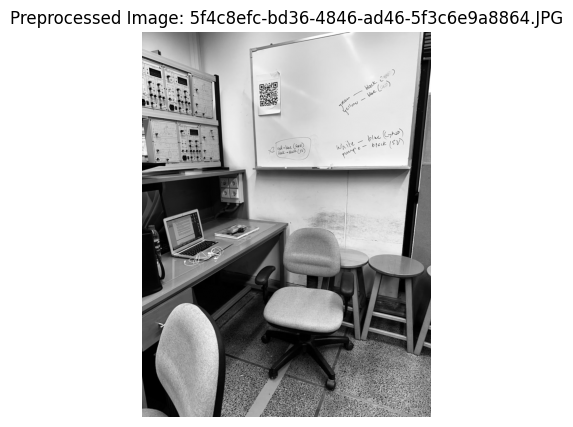

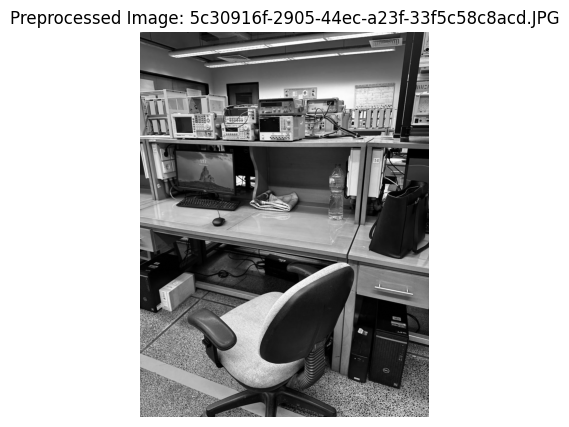

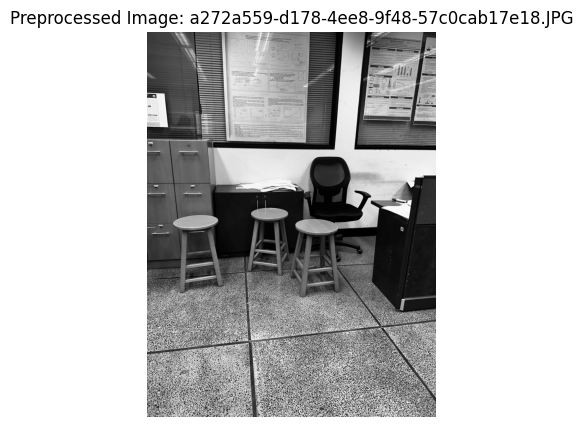

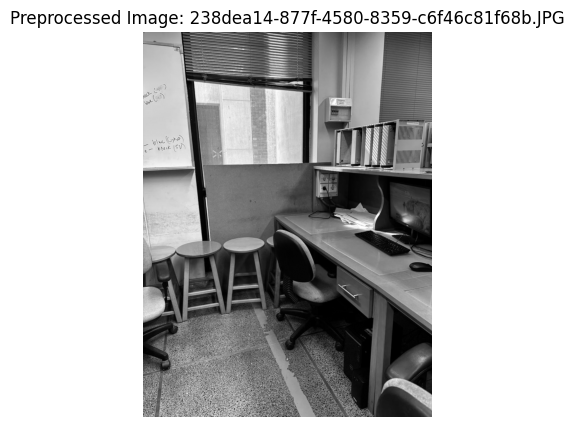

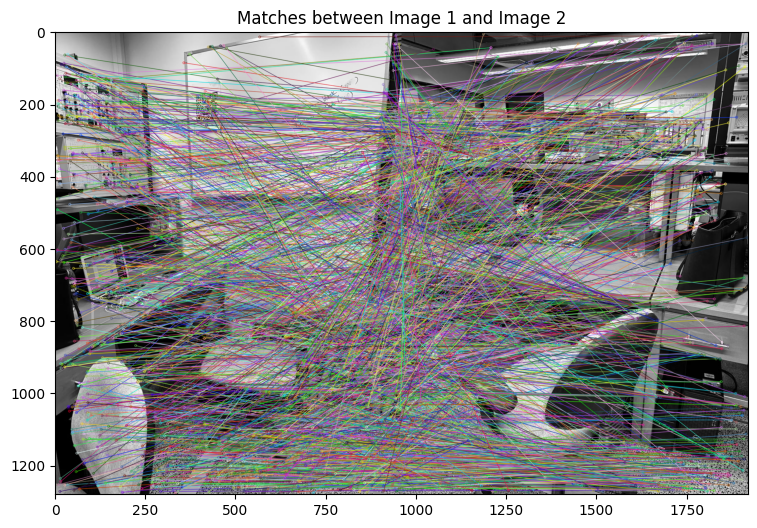

Matched image saved to /content/drive/My Drive/Photo/matched_image_1_2.jpg


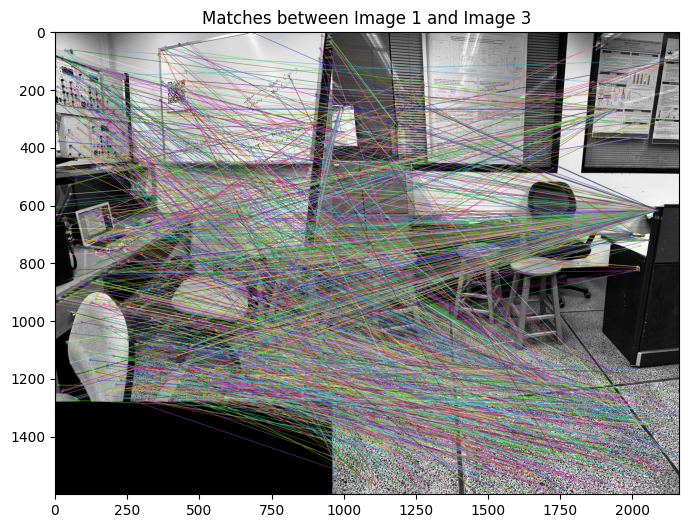

Matched image saved to /content/drive/My Drive/Photo/matched_image_1_3.jpg


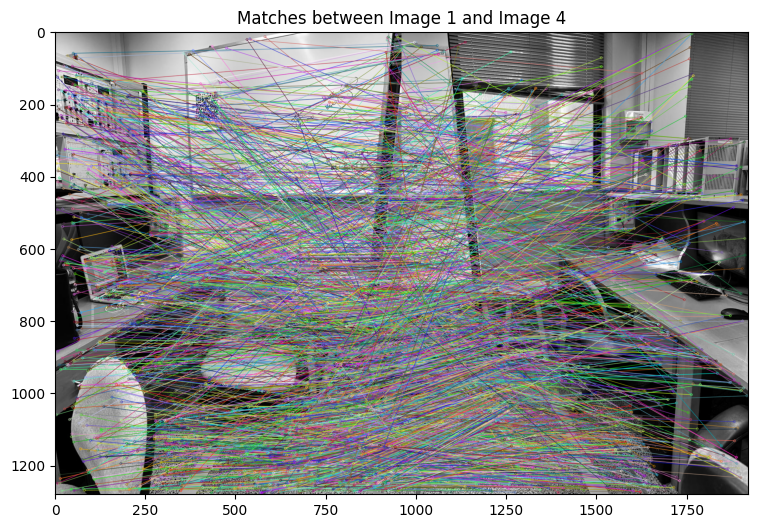

Matched image saved to /content/drive/My Drive/Photo/matched_image_1_4.jpg


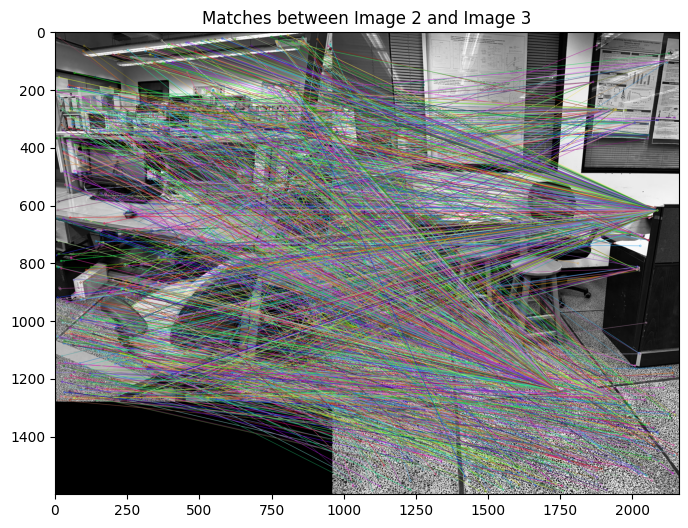

Matched image saved to /content/drive/My Drive/Photo/matched_image_2_3.jpg


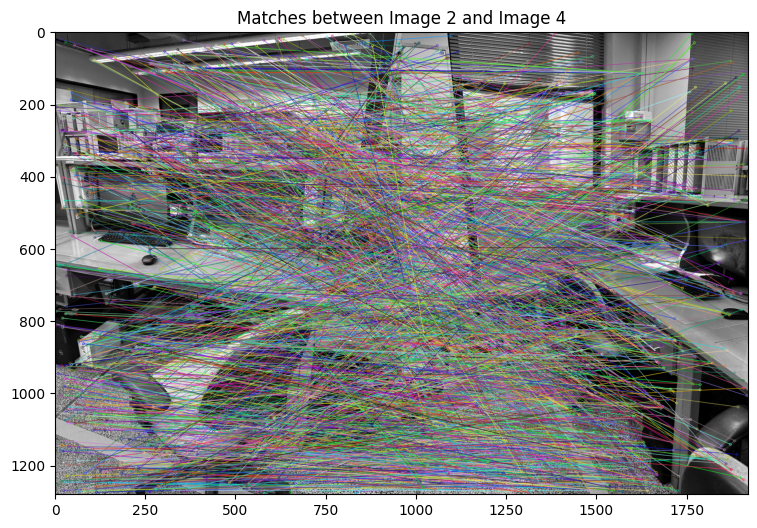

Matched image saved to /content/drive/My Drive/Photo/matched_image_2_4.jpg


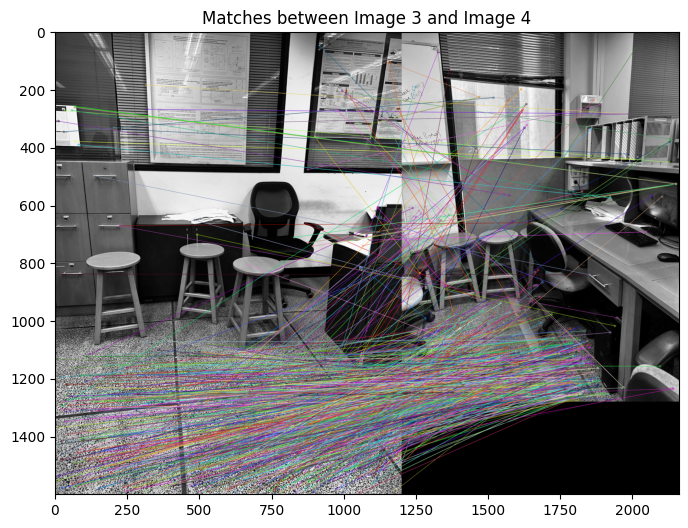

Matched image saved to /content/drive/My Drive/Photo/matched_image_3_4.jpg


In [24]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')
image_folder ="/content/drive/MyDrive/ml/Dataset"



# generate image file names dynamically for .JPEG and .JPG files
image_files = [f for f in os.listdir(image_folder) if f.endswith('.JPEG') or f.endswith('.JPG')]

# filter out any files that don't exist
image_files = [f for f in image_files if os.path.exists(os.path.join(image_folder, f))]

# randomly select 4 images from the available files
if len(image_files) < 4:
    print(f"Warning: Only {len(image_files)} images are available, using all of them.")
    selected_images = image_files  # Use all available images if fewer than 4
else:
    selected_images = random.sample(image_files, 4)

print(f"Selected images for feature matching: {selected_images}")

# preprocess and display the selected images
for img_file in selected_images:
    # load image in grayscale
    img_path = os.path.join(image_folder, img_file)
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # optional preprocessing to resize images to a fixed size
    #image_resized = cv2.resize(image, (500, 500))

    # optional normalization to normalize pixel values to [0, 1] range
    #image_normalized = image_resized / 255.0

    # display the preprocessed image
    plt.figure(figsize=(5, 5))
    plt.imshow(image, cmap='gray')
    plt.title(f'Preprocessed Image: {img_file}')
    plt.axis('off')
    plt.show()

# initialized SIFT detector
sift = cv2.SIFT_create(nfeatures=10000, contrastThreshold=0.03, edgeThreshold=15)

# initialized FLANN based matcher
index_params = dict(algorithm=1, trees=10)  # randomized kd-tree algorithm
search_params = dict(checks=50)  # number of times the tree checkedrecursively
flann = cv2.FlannBasedMatcher(index_params, search_params)

# store keypoints and descriptors
keypoints_list = []
descriptors_list = []
images = []

# load and compute keypoints and descriptors for the selected images
for image_file in selected_images:
    image_path = os.path.join(image_folder, image_file)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    keypoints, descriptors = sift.detectAndCompute(image, None)
    keypoints_list.append(keypoints)
    descriptors_list.append(descriptors)
    images.append(image)

# match features across all pairs of selected images
good_matches_all = []

for i in range(len(images)):
    for j in range(i+1, len(images)):
        # get keypoints and descriptors for the pair of images
        # kp1: list of keypoints (locations, scale, orientation)
        # des1: array of 128-dimensional vectors representing local features
        kp1, des1 = keypoints_list[i], descriptors_list[i]
        kp2, des2 = keypoints_list[j], descriptors_list[j]

        # FLANN based matcher
        matches = flann.knnMatch(des1, des2, k=2)
        # apply Lowe's ratio test
        good_matches = []
        for m, n in matches:
            if m.distance < 0.9 * n.distance:
                good_matches.append(m)
        # store the good matches
        good_matches_all.append((i, j, good_matches, kp1, kp2))

# plot matched features for each pair of selected images
for i, j, good_matches, kp1, kp2 in good_matches_all:
    matched_image = cv2.drawMatches(images[i], kp1, images[j], kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(10, 6))
    plt.imshow(matched_image)
    plt.title(f'Matches between Image {i+1} and Image {j+1}')
    plt.show()

    # save the matched images
    save_path = f'/content/drive/My Drive/Photo/matched_image_{i+1}_{j+1}.jpg'
    cv2.imwrite(save_path, matched_image)
    print(f'Matched image saved to {save_path}')


Using image pair:
   /content/drive/MyDrive/ml/Dataset/01493190-2a84-449e-b628-c43c4a306d65.JPG
   /content/drive/MyDrive/ml/Dataset/1e832918-15de-4ca1-a462-b2ccb3d51f3e.JPG
Image shapes: (1280, 960) (1280, 960)
Computed Intrinsics:
[[960.   0. 480.]
 [  0. 960. 640.]
 [  0.   0.   1.]]

SIFT keypoints: 7208 (img1), 10943 (img2)
Matches after Lowe ratio (ratio=0.85): 1529


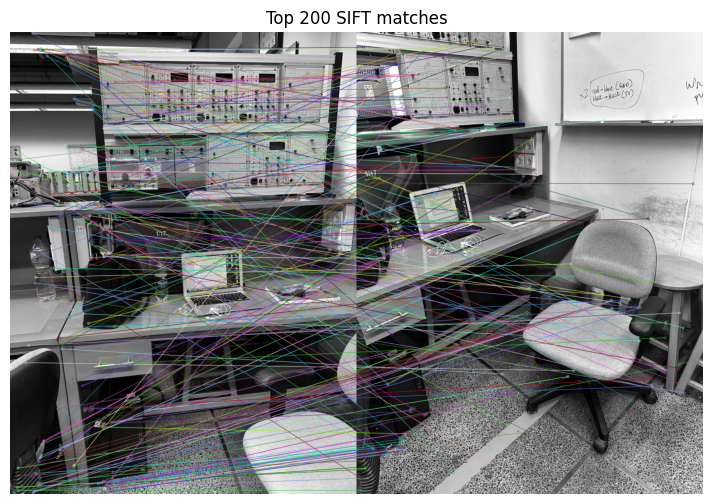


Essential Matrix Estimation:
  Total matches: 1529
  Inliers: 550 (36.0%)
Inlier count after RANSAC: 550

Testing 4 pose candidates:
  Pose 0: 0 points in front of both cameras
  Pose 1: 0 points in front of both cameras
  Pose 2: 0 points in front of both cameras
  Pose 3: 550 points in front of both cameras

Selected pose gives 550 valid points.
Final valid 3D points: 550
Saved point cloud with 550 points to /content/drive/MyDrive/ml/sift_pointcloud_looser.ply


In [28]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


def compute_intrinsics_from_image(img):
    """
    Construct intrinsic matrix K as per project spec:
    fx = fy = image width
    cx, cy = image center
    """
    h, w = img.shape[:2]
    fx = fy = float(w)
    cx = w / 2.0
    cy = h / 2.0

    K = np.array([
        [fx,  0,  cx],
        [ 0, fy, cy],
        [ 0,  0,  1 ]
    ], dtype=np.float64)

    print("Computed Intrinsics:")
    print(K)
    return K

def matches_to_points(kp1, kp2, matches):
    """
    Convert a list of cv2.DMatch objects into Nx2 arrays of (u,v)
    for pts1 and pts2.
    """
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])
    return pts1, pts2


def estimate_essential_ransac(pts1, pts2, K):
    """
    Estimate Essential matrix with RANSAC.
    Returns:
      - E (3x3)
      - inlier_mask (boolean mask)
    """
    E, mask = cv2.findEssentialMat(
        pts1, pts2,
        cameraMatrix=K,
        method=cv2.RANSAC,
        prob=0.999,
        threshold=1.0
    )

    inlier_mask = mask.ravel().astype(bool)

    print("\nEssential Matrix Estimation:")
    print(f"  Total matches: {len(pts1)}")
    print(f"  Inliers: {np.sum(inlier_mask)} ({100*np.mean(inlier_mask):.1f}%)")

    return E, inlier_mask

def triangulate_points(K, R, t, pts1, pts2):
    """
    Triangulate 2D–2D correspondences for a given pose.

    P0 = K [I|0]
    P1 = K [R|t]

    Returns:
      X : Nx3 triangulated points
    """
    P0 = K @ np.hstack([np.eye(3), np.zeros((3, 1))])
    P1 = K @ np.hstack([R, t.reshape(3, 1)])

    pts1_h = pts1.T
    pts2_h = pts2.T

    X_h = cv2.triangulatePoints(P0, P1, pts1_h, pts2_h)
    X = (X_h[:3] / X_h[3]).T  # Nx3

    return X


def count_points_in_front(R, t, X):
    """
    Count how many triangulated points lie in front of BOTH cameras.
    """
    z1 = X[:, 2]  # camera 1

    X2 = (R @ X.T) + t.reshape(3, 1)
    z2 = X2[2, :]  # camera 2

    eps = 1e-6
    valid = (z1 > eps) & (z2 > eps)
    return np.sum(valid), valid

def disambiguate_pose_from_E(E, K, pts1, pts2):
    """
    Decompose Essential matrix E into 4 possible poses.
    For each pose: triangulate → perform cheirality test.
    Return:
      best_R, best_t, best_points (only valid triangulated points)
    """
    R1, R2, t = cv2.decomposeEssentialMat(E)

    pose_candidates = [
        (R1,  t),
        (R1, -t),
        (R2,  t),
        (R2, -t)
    ]

    best_R, best_t, best_X = None, None, None
    best_count = -1

    print("\nTesting 4 pose candidates:")
    for idx, (R, t_candidate) in enumerate(pose_candidates):
        X = triangulate_points(K, R, t_candidate, pts1, pts2)
        count, valid_mask = count_points_in_front(R, t_candidate, X)
        print(f"  Pose {idx}: {count} points in front of both cameras")

        if count > best_count:
            best_count = count
            best_R = R
            best_t = t_candidate
            best_X = X[valid_mask]

    print(f"\nSelected pose gives {best_count} valid points.")
    return best_R, best_t, best_X

def save_point_cloud_ply(filename, points, colors=None):
    """
    Save Nx3 points (and optional Nx3 uint8 colors) to an ASCII PLY.
    """
    points = np.asarray(points, dtype=np.float32)
    N = points.shape[0]

    if colors is None:
        colors = np.ones((N, 3), dtype=np.uint8) * 255  # white

    colors = np.asarray(colors, dtype=np.uint8)

    with open(filename, 'w') as f:
        f.write("ply\n")
        f.write("format ascii 1.0\n")
        f.write(f"element vertex {N}\n")
        f.write("property float x\n")
        f.write("property float y\n")
        f.write("property float z\n")
        f.write("property uchar red\n")
        f.write("property uchar green\n")
        f.write("property uchar blue\n")
        f.write("end_header\n")

        for p, c in zip(points, colors):
            f.write(f"{p[0]} {p[1]} {p[2]} {int(c[2])} {int(c[1])} {int(c[0])}\n")

    print(f"Saved point cloud with {N} points to {filename}")

def detect_and_match_sift(img1, img2, ratio=0.85, nfeatures=12000):
    """
    Detect SIFT keypoints + descriptors in img1 & img2 and match them
    using FLANN + Lowe's ratio test.
    """
    sift = cv2.SIFT_create(nfeatures=nfeatures)

    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    print(f"\nSIFT keypoints: {len(kp1)} (img1), {len(kp2)} (img2)")

    index_params = dict(algorithm=1, trees=5)   # KD-tree
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches_knn = flann.knnMatch(des1, des2, k=2)

    good_matches = []
    for m, n in matches_knn:
        if m.distance < ratio * n.distance:
            good_matches.append(m)

    print(f"Matches after Lowe ratio (ratio={ratio}): {len(good_matches)}")
    return kp1, kp2, good_matches

#Two-view SfM pipeline
image_folder = "/content/drive/MyDrive/ml/Dataset"
image_files = [f for f in os.listdir(image_folder)
               if f.lower().endswith(".jpg") or f.lower().endswith(".jpeg")]
image_files.sort()

# choose first two images
img1_path = os.path.join(image_folder, image_files[0])
img2_path = os.path.join(image_folder, image_files[1])

print("Using image pair:")
print("  ", img1_path)
print("  ", img2_path)

# load grayscale
img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)
print("Image shapes:", img1.shape, img2.shape)

# 1) intrinsics
K = compute_intrinsics_from_image(img1)

# 2) SIFT + matching
kp1, kp2, good_matches = detect_and_match_sift(img1, img2, ratio=0.85, nfeatures=12000)

# quick visualization
matched_vis = cv2.drawMatches(
    img1, kp1, img2, kp2, good_matches[:200], None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)
plt.figure(figsize=(12, 6))
plt.imshow(matched_vis, cmap='gray')
plt.title("Top 200 SIFT matches")
plt.axis('off')
plt.show()

# 3) matches → point arrays
pts1, pts2 = matches_to_points(kp1, kp2, good_matches)

# 4) essential + RANSAC
E, inlier_mask = estimate_essential_ransac(pts1, pts2, K)
pts1_in = pts1[inlier_mask]
pts2_in = pts2[inlier_mask]
print("Inlier count after RANSAC:", pts1_in.shape[0])

# 5) pose disambiguation + triangulation
R, t, X_valid = disambiguate_pose_from_E(E, K, pts1_in, pts2_in)
print("Final valid 3D points:", X_valid.shape[0])

# 6) save point cloud
ply_path = "/content/drive/MyDrive/ml/sift_pointcloud_looser.ply"
save_point_cloud_ply(ply_path, X_valid)
